In [66]:
import pandas as pd
from sklearn.linear_model import LogisticRegression


from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import numpy as np
import mlflow
import warnings

import seaborn as sns
import matplotlib.pyplot as plt 
warnings.filterwarnings("ignore")



from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance



Load Data 

In [48]:
data=pd.read_csv('../data/impression_log.csv',index_col=0)

Select Columns relevant to our analysis

In [49]:
decsisive_data=data[["AdFormat", "FoldPosition", "OS", "DeviceType","engagement"]].copy()

See an overview of our columns and their data types

In [4]:
decsisive_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 00006a06-14e2-47d9-b999-fbeeac67dd2b to 6404d38e-1669-4e0e-b6a4-dab8dc454f45
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   AdFormat      100000 non-null  object 
 1   FoldPosition  100000 non-null  int64  
 2   OS            99993 non-null   float64
 3   DeviceType    100000 non-null  int64  
 4   engagement    100000 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 4.6+ MB


Remove null because they are such a small number of records. The information they would provide is not that much compared to the size of the data set.

In [50]:
decsisive_data.dropna(inplace=True)

See the unique values for each column in our selected data

In [6]:
decsisive_data["OS"].unique()

array([173., 156., 101., 162., 174., 167., 155., 169., 175., 141., 145.,
       154.,   0., 172., 140., 171., 139., 166., 168., 165., 153., 150.,
       136., 144., 112., 161., 170., 163., 164., 159., 160., 148., 157.,
       151., 152., 111., 143., 110., 149., 146., 107., 108., 158., 109.,
       147., 114., 137., 138., 113.])

In [7]:
decsisive_data["FoldPosition"].unique()

array([4, 2, 3], dtype=int64)

In [8]:
decsisive_data["DeviceType"].unique()

array([4, 3, 1], dtype=int64)

In [9]:
decsisive_data["AdFormat"].unique()

array(['300x250', '320x480'], dtype=object)

In [24]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2


# Chi-Squared Test for Independence
.
We can not use pearsons correlation to find if our categorical values and the engagement is independent.  When dealing with the relationships between two categorical variables, we can’t use the same correlation method for continuous variables,​ we will have to employ the use of chi square test for the association.​ That is where the chi squared test comes in. Chi-Square test is a statistical test which is used to find out the difference between the observed and the expected data we can also use this test to find the correlation between categorical variables in our data. 

<pre>If Statistic >= Critical Value: significant result, reject null hypothesis (H0), dependent.
If Statistic < Critical Value: not significant result, fail to reject null hypothesis (H0), independent.
</pre>

We first create crosstabs between our target factor and the engagement columns. We then use this to run our chi test.

In [23]:
def chi_test_dependence(obs: pd.DataFrame, prob:float)->None:
    """Chi Test for independence.Based on code from https://machinelearningmastery.com/chi-squared-test-for-machine-learning/
    Args:
        obs (pd.DataFrame): The cross tab of the two features 
        prob (float): The probaility we want to test at
    """
    stat, p, dof, ex = chi2_contingency(obs, correction=False)

    critical = chi2.ppf(prob, dof)
    print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
    if abs(stat) >= critical:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    # interpret p-value
    alpha = 1.0 - prob
    print('significance=%.3f, p=%.3f' % (alpha, p))
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')

In [25]:
obs=pd.crosstab(index=decsisive_data['AdFormat'], columns=decsisive_data['engagement'])
chi_test_dependence(obs,0.95)

probability=0.950, critical=3.841, stat=1424.750
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


In [26]:
obs=pd.crosstab(index=decsisive_data['FoldPosition'], columns=decsisive_data['engagement'])
chi_test_dependence(obs,0.95)

probability=0.950, critical=5.991, stat=86.845
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


In [27]:
obs=pd.crosstab(index=decsisive_data['OS'], columns=decsisive_data['engagement'])
chi_test_dependence(obs,0.95)

probability=0.950, critical=65.171, stat=257.738
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


In [28]:
obs=pd.crosstab(index=decsisive_data['DeviceType'], columns=decsisive_data['engagement'])
chi_test_dependence(obs,0.95)

probability=0.950, critical=5.991, stat=749.130
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


We can see that all of the features have a dependent relationship with our target engagment'


# ML Feature Importance
Feature importance refers to techniques that assign a score to input features based on how useful they are at predicting a target variable. This tells us the a bit about the influence that these features have on engagement.

Separating our target and training features from the data

In [52]:
y=decsisive_data["engagement"]
X=decsisive_data.drop("engagement",axis=1,inplace=False)
columns=X.columns.to_list()

Train test split that we will use later to test the robustness of our model as well as the permutuation importance

In [53]:

x_train, x_test, y_train, y_test=train_test_split(X,y,test_size=0.3)

I will be using a random forest classifier as the model for this. We use one hot encoding to encode the features because we don't want to assign any ordinality to the categories. The ordinality created by label encoder or ordinal encoder can result in faulty calculations in our model where category A can be less than category B when that isn't inherent in the data. 

In [67]:
mlflow.sklearn.autolog()
with mlflow.start_run(run_name="RandomForest"):
    pipe = Pipeline(steps=[('encoding', OneHotEncoder(handle_unknown='ignore')), ('forest',  RandomForestClassifier(random_state=42))])
    pipe.fit(x_train, y_train)
mlflow.end_run()

2021/10/01 11:23:06 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


Our Accuracy scores for the model. The model performs relatively well with 87% accuracy on the train and 87.2% on the test

In [73]:
print("RF train accuracy: %0.3f" % pipe.score(x_train, y_train))
print("RF test accuracy: %0.3f" % pipe.score(x_test, y_test))

RF train accuracy: 0.870
RF test accuracy: 0.872


The feature importances from the random forest model. We can see that the low cardinality features have higher spots. This maybe because impurity-based feature importance can inflate the importance of numerical features. More can be read <a href="https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html">Permutation Importance vs Random Forest Feature Importance (MDI)</a>. This also doesn't give us the importance of the features overall. We can see that the highest spots are taken by AdFormat, DeviceType, FoldPosition, OS respectively.

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

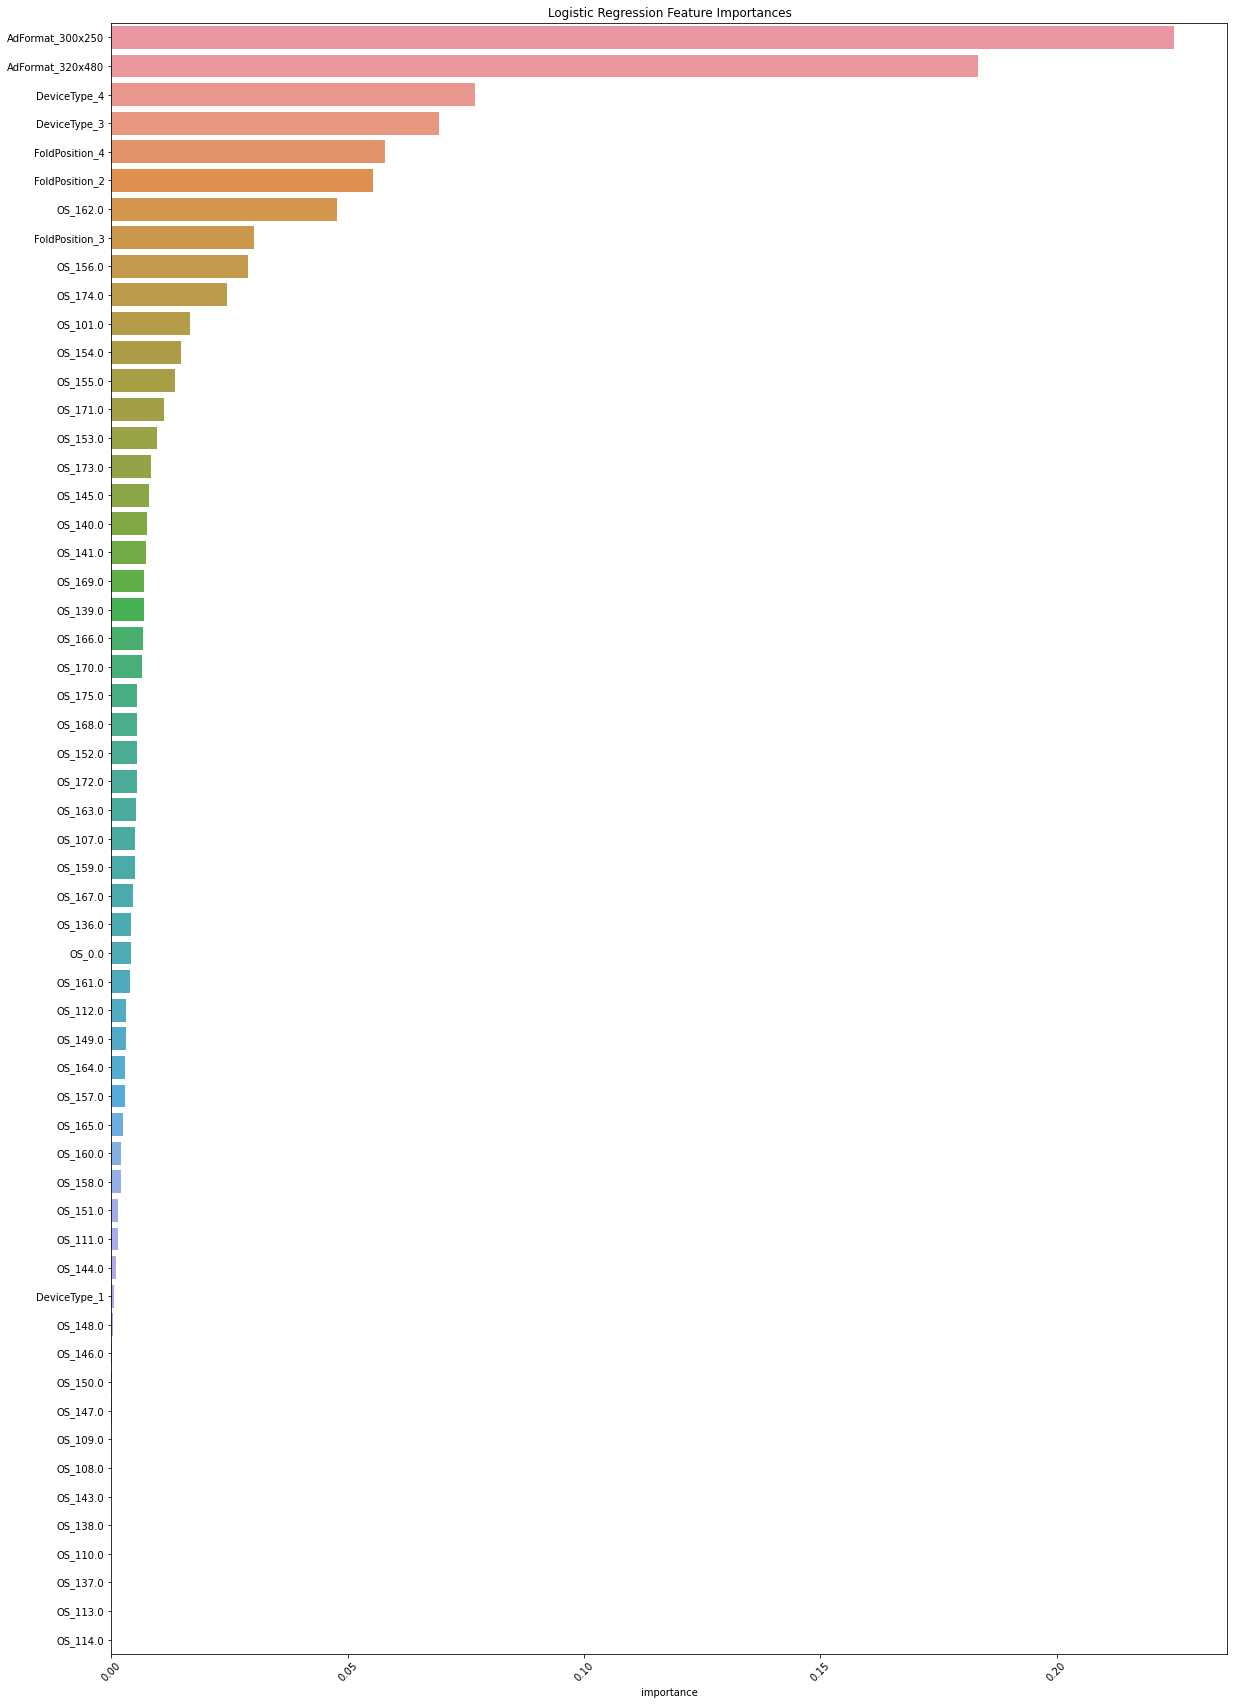

In [69]:
ohe = (pipe.named_steps['encoding'])
feature_names = ohe.get_feature_names_out(X.columns.to_list())


feature_importances=pd.DataFrame((pipe.named_steps['forest'].feature_importances_).transpose() , index=feature_names, columns=['importance'])
feature_importances.sort_values('importance',key=abs, ascending=False,inplace= True)
plt.figure(figsize = (20,30))
sns.barplot(y = feature_importances.index, x = feature_importances.importance)
plt.title('Logistic Regression Feature Importances')
plt.xticks(rotation = 45)


# Permutation feature importance
.
The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled 1. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. We will use the random forest classifier model trained in previous step for this. 


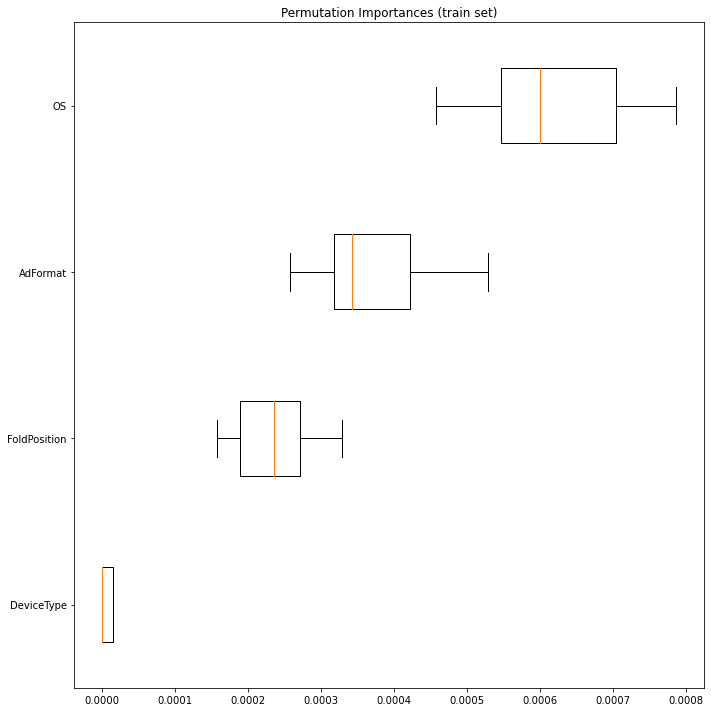

In [71]:
result = permutation_importance(pipe, x_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize = (10,10))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=x_train.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

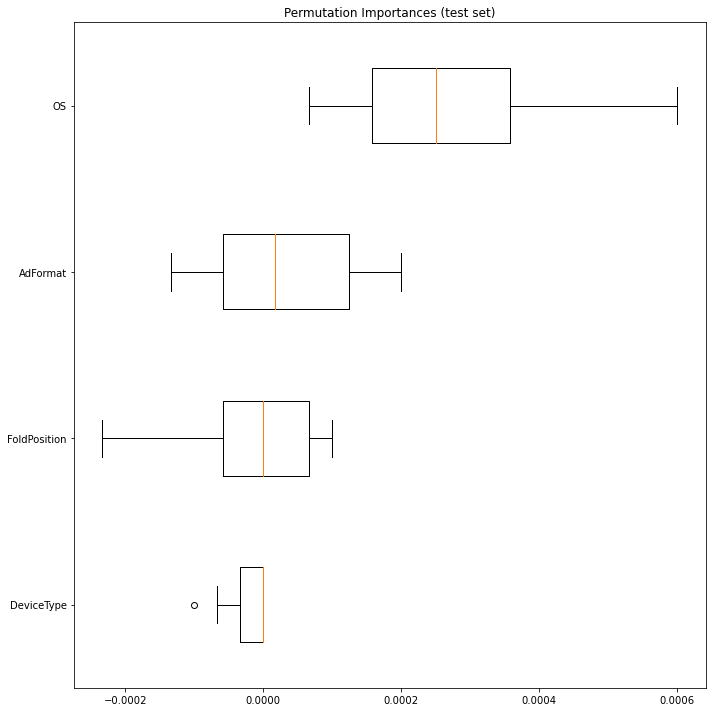

In [74]:

result = permutation_importance(pipe, x_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize = (10,10))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=x_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

## Conclusion

When using the permutation feature importance. We can see that the order of importance is OS, AdFormat, FoldPosition, DeviceType. We can conclude the level of decisiveness to be similar to our feature importance findings. 
